### Intenet Meme Evolution and Single Linkage Clustering


In Internet meme pictures with captions, the picture often remains constant while the captions vary over time:

* most of the modifications are minor variations
* sometimes abrupt changes in the text or image occur

These two processes occur simultaneously with different occurrence rates. Minor variations of existing memes are much more common than emergence of a new idea. In this notebook, we define a simplified random process that mimics the basic aspects of meme generation and explores how nearest linkage clustering is related to this process. 

In [1]:
import numpy as np
import pandas as pd
import numpy.random as rnd
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hclust 
import sklearn

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from tqdm import tnrange#, tqdm_notebook
from plotnine import *

from scipy.stats import norm
from scipy.stats import multivariate_normal



from sklearn.cluster import AgglomerativeClustering

# Local imports
from common import *
from convenience import *

## I. Simplified two-step model for meme generation process

We are going to illustrate meme generation through generating points on a plane, rather than complex sentences, as the relation between points is easier to visualise and interpret. However, the same procedure can be naturally extended to the original domain.

* **Step type choice.**
Parameter $\varrho$ determines the probability for an abrupt change or a minor variation. Step type choices are independent throughout the evolution of the system. 

* **Minor modification.**
We randomly choose an existing meme $\boldsymbol{x}_i$ and modify it by adding white Gaussian noise with low variance $\boldsymbol{\varepsilon}_i\sim\mathcal{N}(0, \sigma_1\boldsymbol{\mathrm I})$. The meme to be modified $\boldsymbol{x}_i$ is chosen uniformly from all generated memes after the last seed generation.  

* **Seed generation.** 
We still choose an existing meme $\boldsymbol{x}_i$ and modify it by adding white Gaussian noise with high variance $\boldsymbol{\varepsilon}_i\sim\mathcal{N}(0, \sigma_2\boldsymbol{\mathrm I})$. The meme to be modified $\boldsymbol{x}_i$ is chosen uniformly from all generated memes after the last seed generation.

### Implementation

In [2]:
def meme_generation(n: int, seed: List[float]=[0,0], rho: float=0.1, sigma1: float=0.01, sigma2: float=1)->DataFrame:
    z = rnd.uniform(size=n) <= rho
    x = np.full([n + 1,2], np.nan)
    x[0,:] = seed
    i0 = 0;
    source = np.full([n+1], -1, dtype=int)
    for i, seed in enumerate(z):
        source[i + 1] = rnd.choice(range(i0, i + 1))
        #source[i + 1] = rnd.choice(range(i+1))
        if seed:
            i0 = i + 1
            x[i + 1, :] = x[source[i + 1], :] + rnd.normal(scale=sigma2, size=2)
        else:
            x[i + 1, :] = x[source[i + 1], :] + rnd.normal(scale=sigma1, size=2)
            
    return DataFrame(x, columns = ['x', 'y']).assign(seed =  np.insert(z, 0, True)).assign(source = source)        

In [3]:
meme_generation(10, rho=0.3, sigma1=0.01, sigma2=0.3)

,x,y,seed,source
0,0.000000,0.000000,True,-1
1,0.186781,0.031728,True,0
2,0.182926,0.031850,False,1
3,0.181495,0.026778,False,2
4,0.169660,0.045771,False,1
5,0.199582,0.039030,False,1
6,0.174748,0.049808,False,1
7,0.236581,0.133128,True,1
8,0.236701,0.142471,False,7
9,0.232611,0.141877,False,7


### Visualisations

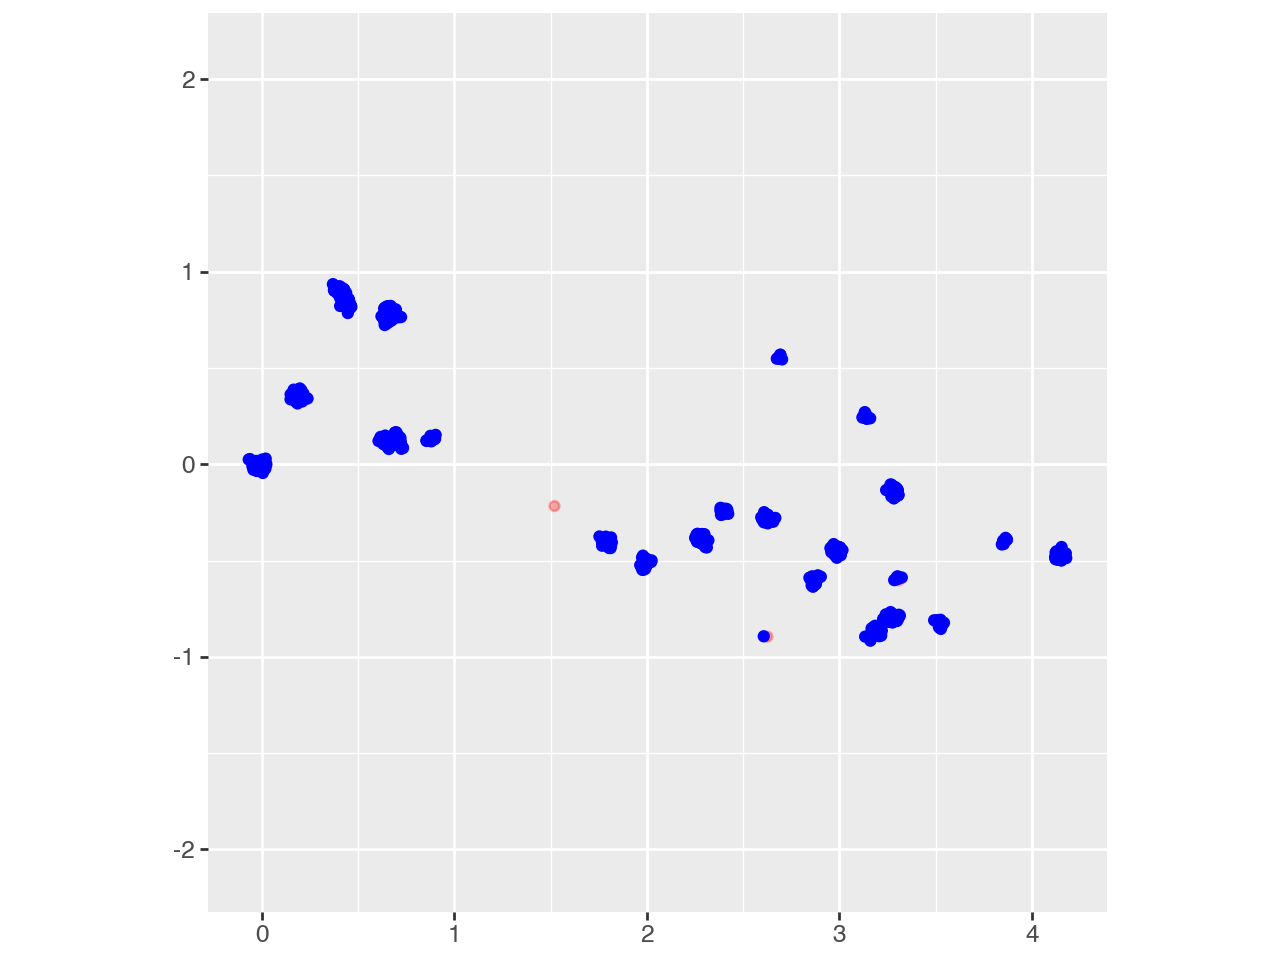

In [4]:
df = meme_generation(1000, rho=0.02, sigma1=0.01, sigma2=0.3)

Delta = 0.5 * max(df['x'].max()-df['x'].min(),df['y'].max()-df['y'].min())
xc = 0.5 * (df['x'].max() + df['x'].min())
yc = 0.5 * (df['y'].max() + df['y'].min())

p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'seed', alpha = 'seed'))
p = p + scale_alpha_manual(values=[0.3,1], breaks=[True, False], guide = None)
p = p + scale_color_manual(values=['red','blue'], breaks=[True, False], guide = None)
p = p + coord_fixed(ratio=1, xlim = [xc - Delta, xc + Delta], ylim = [yc - Delta, yc + Delta])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)
p.save('meme_generation_i.pdf', path='results', height=6, width=6, verbose=False)

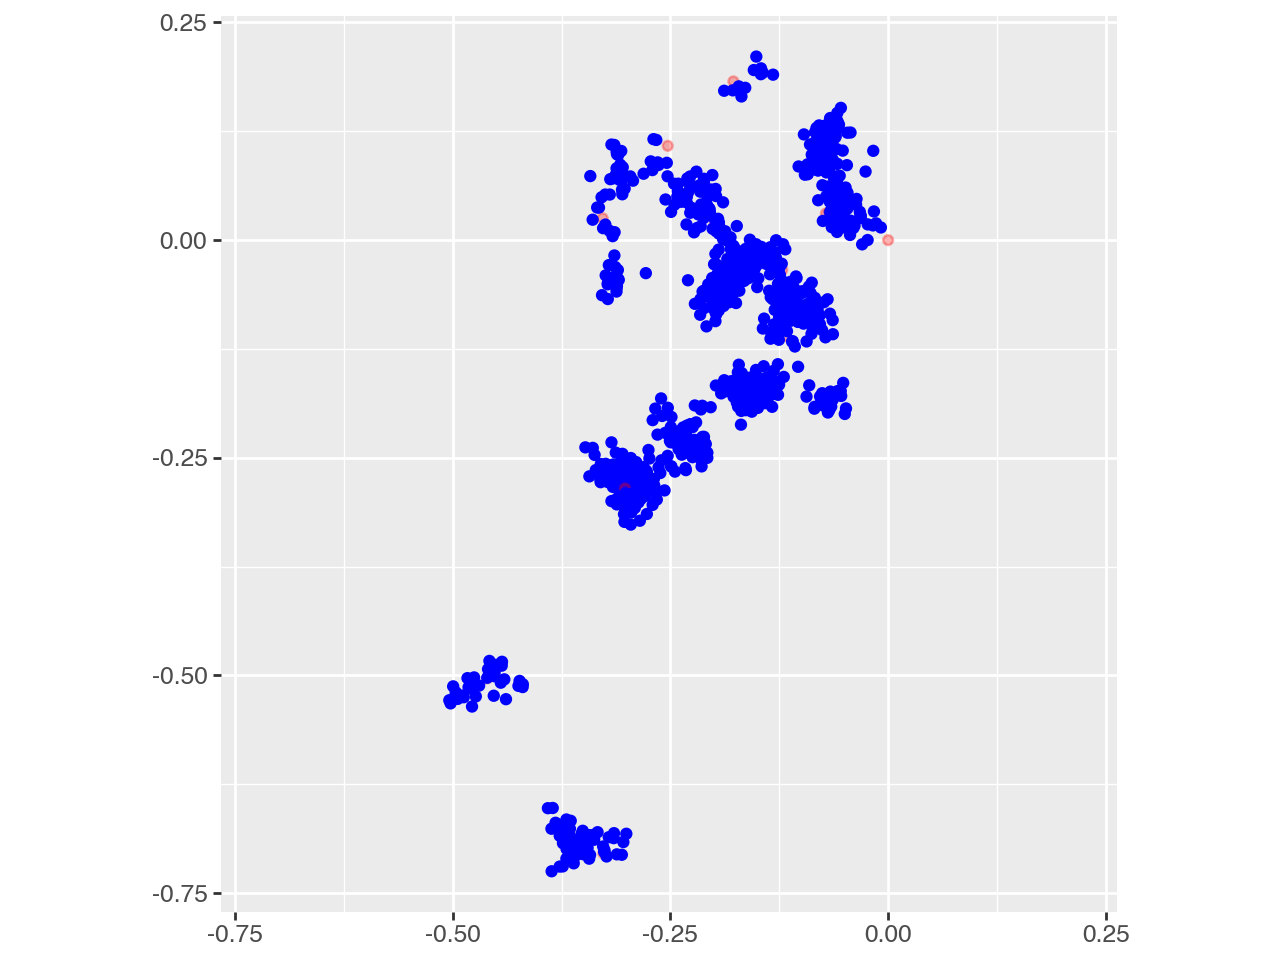

In [5]:
df = meme_generation(1000, rho=0.02, sigma1=0.01, sigma2=0.1)

Delta = 0.5 * max(df['x'].max()-df['x'].min(),df['y'].max()-df['y'].min())
xc = 0.5 * (df['x'].max() + df['x'].min())
yc = 0.5 * (df['y'].max() + df['y'].min())

p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'seed', alpha = 'seed'))
p = p + scale_alpha_manual(values=[0.3,1], breaks=[True, False], guide = None)
p = p + scale_color_manual(values=['red','blue'], breaks=[True, False], guide = None)
p = p + coord_fixed(ratio=1, xlim = [xc - Delta, xc + Delta], ylim = [yc - Delta, yc + Delta])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)
p.save('meme_generation_ii.pdf', path='results', height=6, width=6, verbose=False)

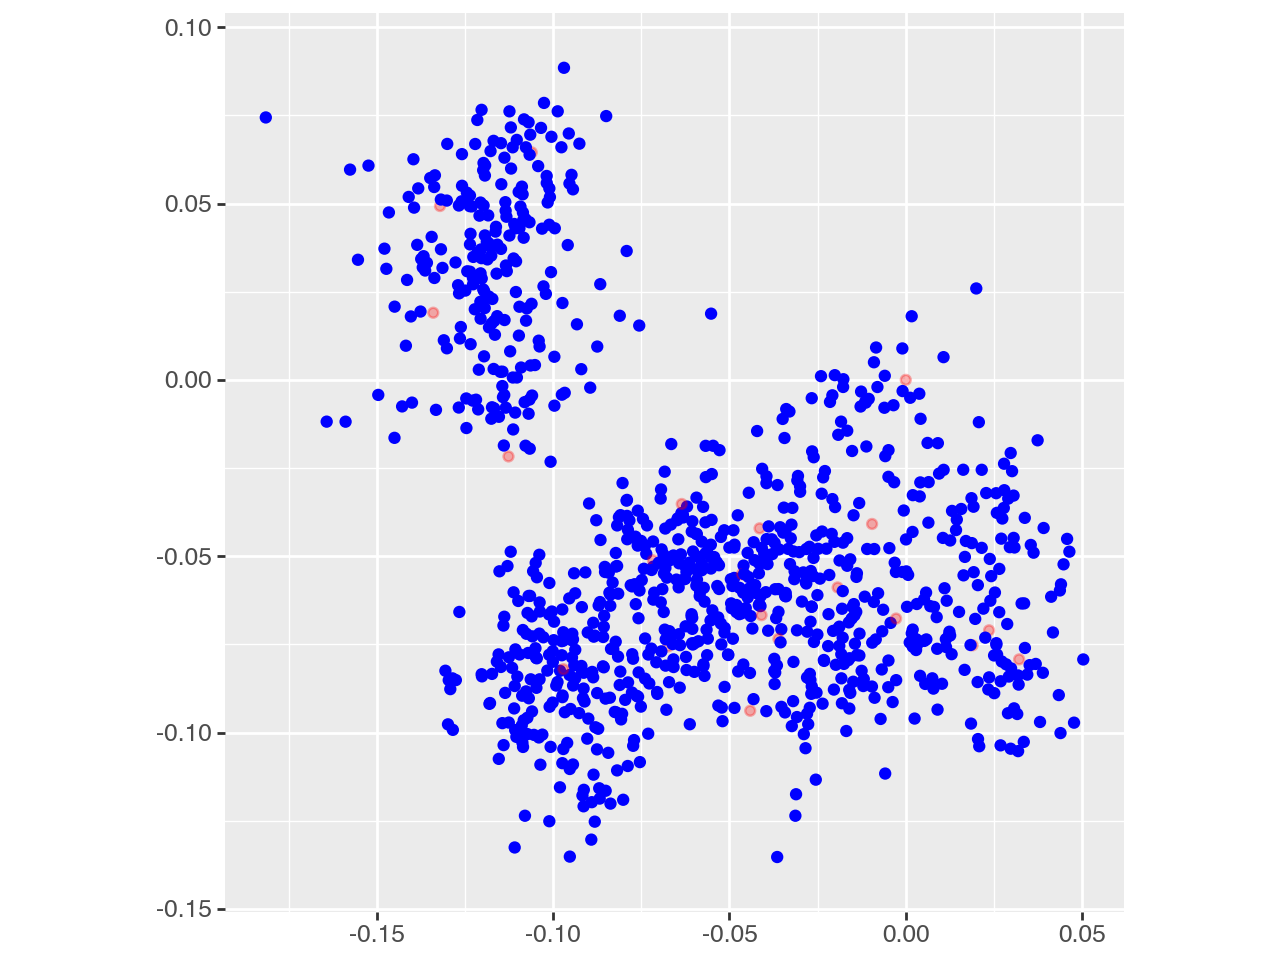

In [6]:
df = meme_generation(1000, rho=0.02, sigma1=0.01, sigma2=0.03)

Delta = 0.5 * max(df['x'].max()-df['x'].min(),df['y'].max()-df['y'].min())
xc = 0.5 * (df['x'].max() + df['x'].min())
yc = 0.5 * (df['y'].max() + df['y'].min())

p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'seed', alpha = 'seed'))
p = p + scale_alpha_manual(values=[0.3,1], breaks=[True, False], guide = None)
p = p + scale_color_manual(values=['red','blue'], breaks=[True, False], guide = None)
p = p + coord_fixed(ratio=1, xlim = [xc - Delta, xc + Delta], ylim = [yc - Delta, yc + Delta])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)
p.save('meme_generation_iii.pdf', path='results', height=6, width=6, verbose=False)

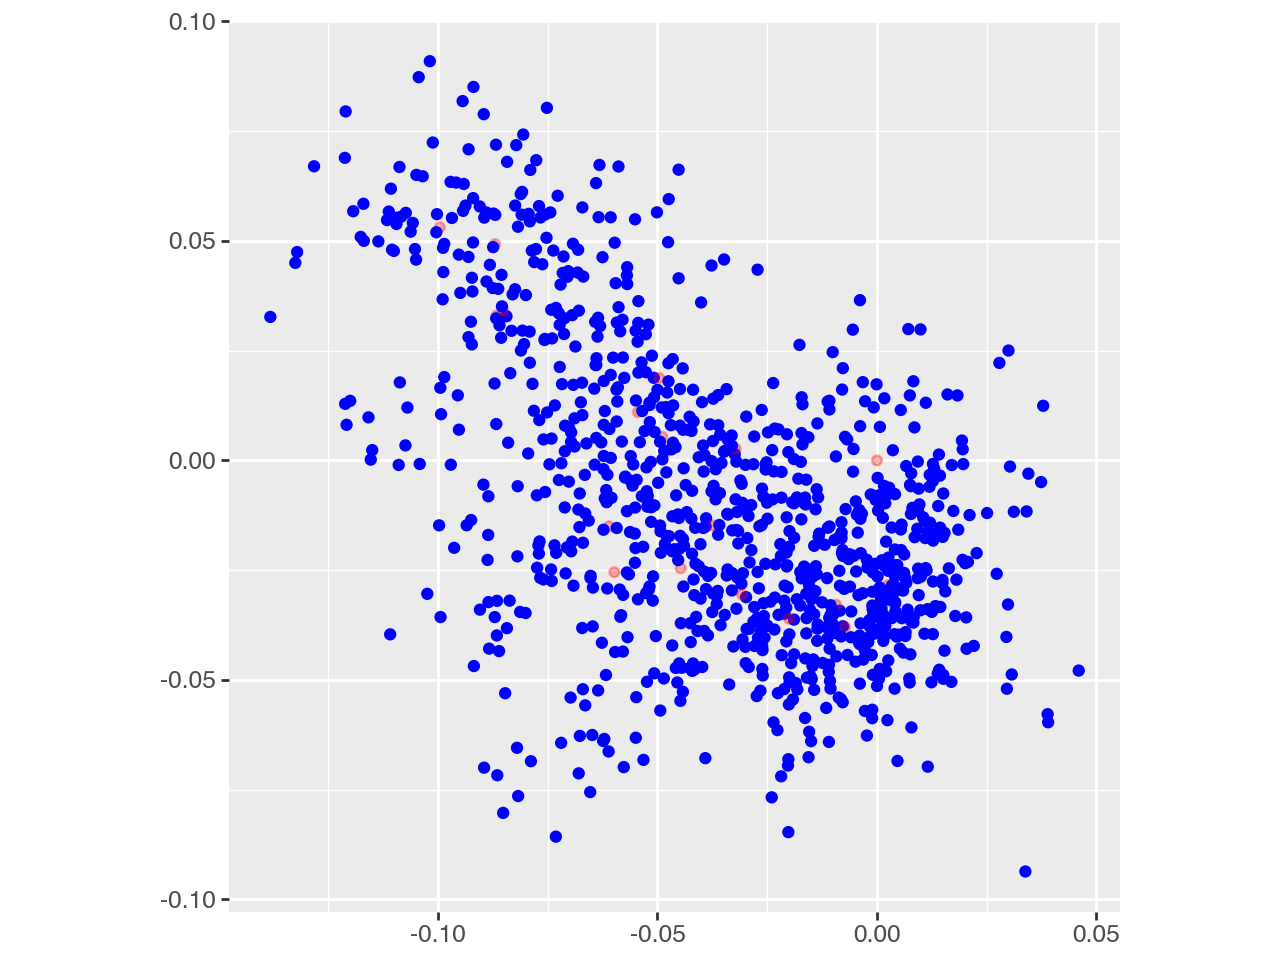

In [7]:
df = meme_generation(1000, rho=0.02, sigma1=0.01, sigma2=0.01)

Delta = 0.5 * max(df['x'].max()-df['x'].min(),df['y'].max()-df['y'].min())
xc = 0.5 * (df['x'].max() + df['x'].min())
yc = 0.5 * (df['y'].max() + df['y'].min())

p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'seed', alpha = 'seed'))
p = p + scale_alpha_manual(values=[0.3,1], breaks=[True, False], guide = None)
p = p + scale_color_manual(values=['red','blue'], breaks=[True, False], guide = None)
p = p + coord_fixed(ratio=1, xlim = [xc - Delta, xc + Delta], ylim = [yc - Delta, yc + Delta])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)
p.save('meme_generation_iv.pdf', path='results', height=6, width=6, verbose=False)

## II. Observed memes and the modification tree

In practice, the meme generation process is much more complicated and we do not know whether a particular meme $\boldsymbol{x}_i$ is an original meme or not. We can model this by stating that we receive only randomly permuted set of memes $\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n$ and our task is to reconstruct the meme generation process as best as we can.

For that note that each meme $\boldsymbol{x}_{i}$ is connected with at least one other meme $\boldsymbol{x}_i$ through the following links:
* $\boldsymbol{x}_i$ was created from $\boldsymbol{x}_j$ via minor modification
* $\boldsymbol{x}_j$ was created from $\boldsymbol{x}_i$ via minor modification
* $\boldsymbol{x}_i$ was created from $\boldsymbol{x}_j$ via major modification
* $\boldsymbol{x}_j$ was created from $\boldsymbol{x}_i$ via major modification

If we omit the directionality information, then we must find a tree that covers all points $\boldsymbol{x}_i$ and has edges of two colors: red for major changes and blue for minor changes. We refer to this graph as modification tree. See the figure below for an illustration.  

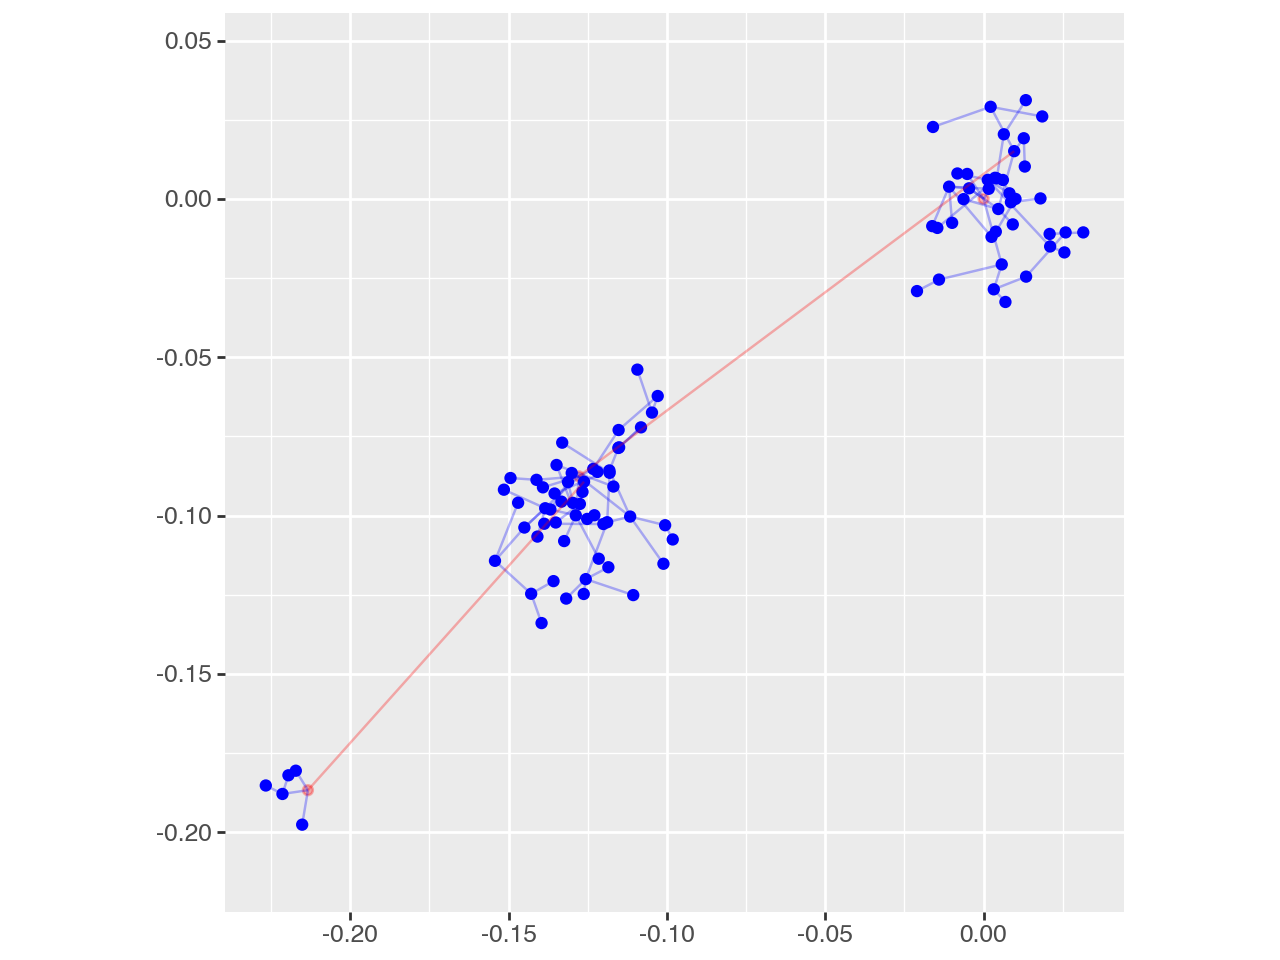

In [8]:
df = meme_generation(100, rho=0.05, sigma1=0.01, sigma2=0.1)

sec = (df[1:]
       .assign(x0 = lambda df2: df.loc[df2['source'], 'x'].values)
       .assign(y0 = lambda df2: df.loc[df2['source'], 'y'].values)
       .rename(columns = {'x':'x1', 'y':'y1'})
       [['x0', 'y0', 'x1', 'y1', 'seed']]
) 

Delta = 0.5 * max(df['x'].max()-df['x'].min(),df['y'].max()-df['y'].min())
xc = 0.5 * (df['x'].max() + df['x'].min())
yc = 0.5 * (df['y'].max() + df['y'].min())

p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'seed', alpha = 'seed'))
p = p + geom_segment(aes(x = 'x0', y =  'y0', xend = 'x1', yend = 'y1', color = 'seed'), data = sec, alpha = 0.3)
p = p + scale_alpha_manual(values=[0.3,1], breaks=[True, False], guide = None)
p = p + scale_color_manual(values=['red','blue'], breaks=[True, False], guide = None)
p = p + coord_fixed(ratio=1, xlim = [xc - Delta, xc + Delta], ylim = [yc - Delta, yc + Delta])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

## III. Maximum likelihood reconstruction of a modification tree in a cluster

Let us assume that all points are generated via minor modifications from previous points. Then we can ask what is the most likely generation tree $\mathcal{T}$. For fixed order of points $\boldsymbol{x}_0,\ldots,\boldsymbol{x}_n$ and source indexes $s_1,\ldots,s_n$, we can express 

\begin{align*}
p[\boldsymbol{x}_0,\ldots,\boldsymbol{x}_n|\mathcal{T}]=
p[\boldsymbol{x}_0,\ldots,\boldsymbol{x}_n|s_1,\ldots,s_n]
\end{align*}

as source indices completely determine the tree. As a result, we can express the likelihood

\begin{align*}
p[\boldsymbol{x}_0,\ldots,\boldsymbol{x}_n|\mathcal{T}]= p[\boldsymbol{x}_0] \cdot \prod_{i=1}^n p[\boldsymbol{x}_{s_i} \to\boldsymbol{x}_i] \propto \prod_{i=1}^n p[\boldsymbol{x}_{s_i} \to\boldsymbol{x}_i]\enspace.
\end{align*}

From this it is straightforward to observe that maximum likelihood assignment of sources $s_1,\ldots,s_n$ can be found 

\begin{align*}
  s_i = \mathrm{argmin}_{j<i} p[\boldsymbol{x}_{j} \to\boldsymbol{x}_i]\,.
\end{align*}

Note that log-likelihood can be expressed as

\begin{align*}
\log p[\boldsymbol{x}_0,\ldots,\boldsymbol{x}_n|\mathcal{T}] = const + \sum_{i=1}^n\log p[\boldsymbol{x}_{s_i} \to\boldsymbol{x}_i]\,.
\end{align*}

If we do not know the generation order we must compute the minimising assignment for each reordering of $\boldsymbol{x}_0,\ldots,\boldsymbol{x}_n$ and choose the one with the maximla likelihood. 
However there is a shortcut.
Namely, the log-likelihood is maximised if we find a spanning tree for a graph where each node pair $(\boldsymbol{x}_i$, $\boldsymbol{x}_j)$ is connected via an edge of length $d_{ij}=-\log\Pr[\boldsymbol{x}_j \to\boldsymbol{x}_i]$. As $d_{ij}\geq 0$ we can use [Kruskal algorithm](https://en.wikipedia.org/wiki/Kruskal%27s_algorithm):

* Connect nodes with the shortest edge provided they are not already connected.
* Repeat the previous step until all nodes are connected. 

For white Gaussian noise, the above probabilities are inversely proportional to distances squared and thus Kruskal algorithm is equivalent to [single linkage clustering algorithm](https://en.wikipedia.org/wiki/Single-linkage_clustering): 

* [scipy.cluster.hierarchy.single](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.single.html#scipy.cluster.hierarchy.single)
* [scipy.cluster.hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage)
* [sklearn.cluster.AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)

Unfortunately, the output of the implementations of single linkage clustering algorithm remembers only when points were joined to clusters and not what were the corresponding links $\boldsymbol{x}_i\leftrightarrow\boldsymbol{x}_j$. Hence, we need to implement Kruskal algorithm ourselves to get a better visualisation.   

### Barebone implementation of Kruskal algorithm

In [9]:
def compute_distances(df: DataFrame) -> DataFrame:
    "Computes distances between row vectors of the data frame"
    
    n = len(df)
    dist = np.full([int(0.5 * n *(n-1)), 3], np.nan)
    
    k = 0
    for i in range(len(df)):
        for j in range(i):
            d = np.sum((df.loc[i, ['x', 'y']] - df.loc[j, ['x', 'y']])**2)
            dist[k, :] = [i, j, d]
            k += 1
    
    return DataFrame(dist, columns = ['i', 'j', 'distance_sq']).astype({"i": int, "j": int}) 

In [10]:
dist = compute_distances(df.loc[:5])

In [11]:
def kruskal(dist: DataFrame) -> DataFrame:
    "Naive implementation of Kruskal algorithm"
    
    L = []
    clusters = []

    for _,row in dist.sort_values(['distance_sq']).iterrows():
    
        # Find clusters containing the end points of the edge  
        i0 = [i for i, cluster in enumerate(clusters) if row.iloc[0] in cluster]
        i1 = [i for i, cluster in enumerate(clusters) if row.iloc[1] in cluster]

        # Abort as we have a loop
        if i0 and (i0 == i1):
            continue

        L.append([int(row.iloc[0]), int(row.iloc[1])])
        

        # Update clusters
        if not i0 and not i1:
            clusters.append({row.iloc[0], row.iloc[1]})

        elif i0 and i1:
            clusters[i0[0]] |= clusters[i1[0]]
            del clusters[i1[0]]

        elif i0:
            clusters[i0[0]].add(row.iloc[1])

        elif i1:
            clusters[i1[0]].add(row.iloc[0])

    return DataFrame(L, columns = ['i', 'j'])

In [56]:
display(kruskal(dist))

,i,j
0,5,4
1,1,0
2,3,0
3,2,0
4,4,2


### Corresponding visualisation

In [12]:
df = meme_generation(50, rho=0.00, sigma1=0.01, sigma2=0.1)

In [13]:
L = kruskal(compute_distances(df))

paths = pd.concat([
    df.loc[L['i'], ['x', 'y']].reset_index(drop=True).rename(columns = {'x':'x0', 'y':'y0'}), 
    df.loc[L['j'], ['x', 'y']].reset_index(drop=True).rename(columns = {'x':'x1', 'y':'y1'})], axis=1)

In [59]:
head(paths)

,x0,y0,x1,y1
0,0.023090,-0.023920,0.022483,-0.023830
1,0.022996,-0.020359,0.023980,-0.019324
2,-0.001512,-0.000789,0.000000,0.000000
3,0.014819,-0.023423,0.013428,-0.022319
4,0.045920,0.015529,0.046703,0.013616


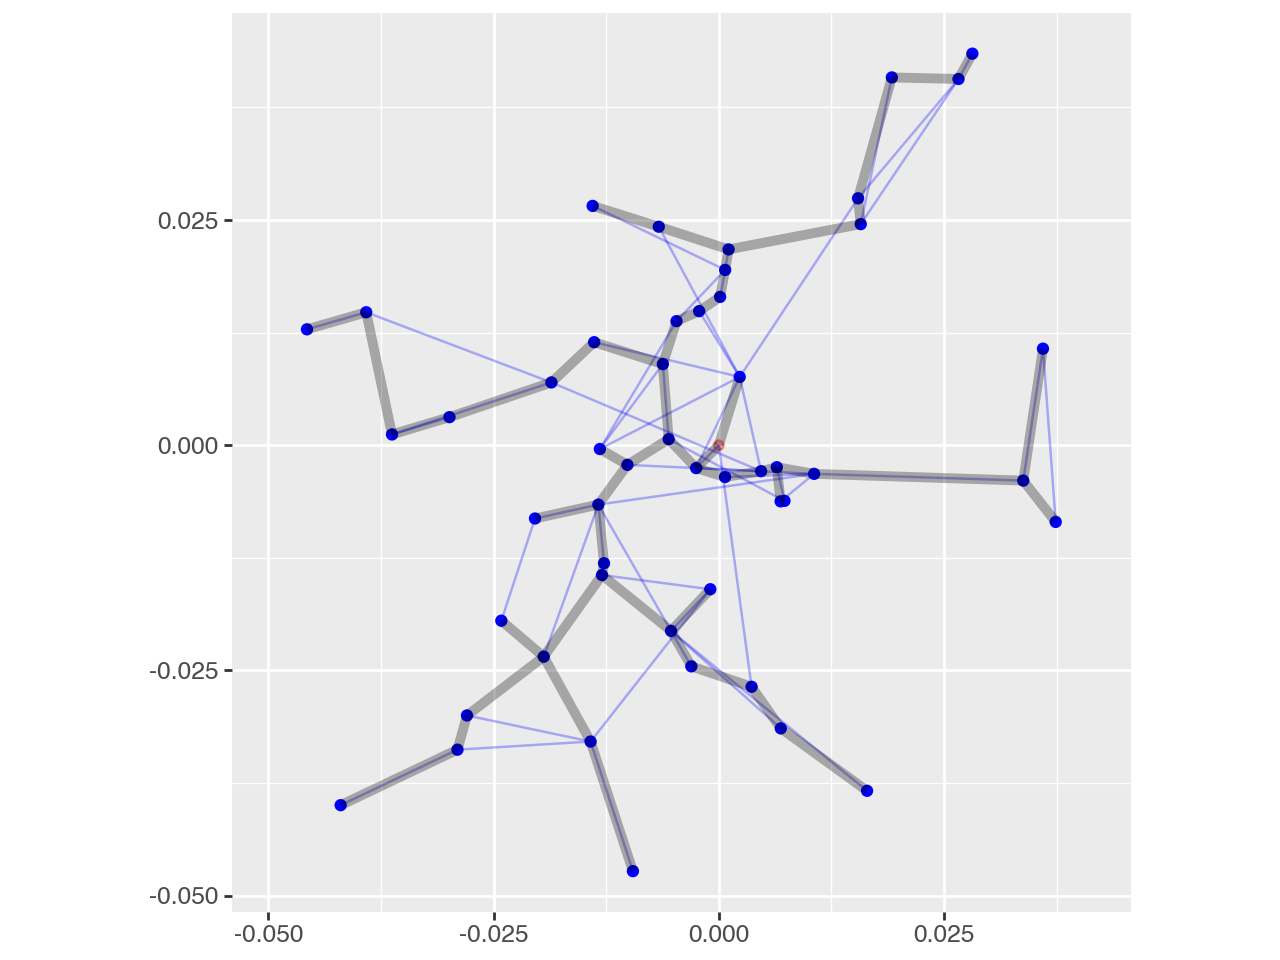

In [14]:
sec = (df[1:]
       .assign(x0 = lambda df2: df.loc[df2['source'], 'x'].values)
       .assign(y0 = lambda df2: df.loc[df2['source'], 'y'].values)
       .rename(columns = {'x':'x1', 'y':'y1'})
       [['x0', 'y0', 'x1', 'y1', 'seed']]
) 

Delta = 0.5 * max(df['x'].max()-df['x'].min(),df['y'].max()-df['y'].min())
xc = 0.5 * (df['x'].max() + df['x'].min())
yc = 0.5 * (df['y'].max() + df['y'].min())

p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'seed', alpha = 'seed'))
p = p + geom_segment(aes(x = 'x0', y =  'y0', xend = 'x1', yend = 'y1', color = 'seed'), data = sec, alpha = 0.3)
p = p + geom_segment(aes(x = 'x0', y =  'y0', xend = 'x1', yend = 'y1'), data = paths, color = 'black', alpha = 0.3, size=2)
p = p + scale_alpha_manual(values=[0.3,1], breaks=[True, False], guide = None)
p = p + scale_color_manual(values=['red','blue'], breaks=[True, False], guide = None)
p = p + coord_fixed(ratio=1, xlim = [xc - Delta, xc + Delta], ylim = [yc - Delta, yc + Delta])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

As you can see, the maximum likelihood explanation is quite far from the actual evolution in this case. This is expected as it would be very unlikely that a randomly generated graph would be the minimal spanning tree of itself.

## V. Maximum aposteriori reconstruction

Note that the data generation model completely determines joint probability of treeshape and observations

\begin{align*}
p[\boldsymbol{x}_0,\ldots,\boldsymbol{x}_n\wedge \mathcal{T}]&=
p[\boldsymbol{x}_0,\ldots,\boldsymbol{x}_n,s_1,\ldots,s_n]\\
&= p[\boldsymbol{x}_0] \cdot \prod_{i=1}^n \Pr[s_i | \boldsymbol{x}_0, \dots, \boldsymbol{x}_{i-1}]\cdot p[\boldsymbol{x}_{s_i} \to\boldsymbol{x}_i] \\
&= p[\boldsymbol{x}_0] \cdot \prod_{i=1}^n\frac{1}{i}\cdot p[\boldsymbol{x}_{s_i} \to\boldsymbol{x}_i] \\
&=p[\boldsymbol{x}_0,\ldots,\boldsymbol{x}_n|\mathcal{T}] \cdot \prod_{i=1}^n\frac{1}{i}\enspace.
\end{align*}

Thus, we can conclude that the model assigns a constant prior to all threeshapes  

\begin{align*}
\Pr[\mathcal{T}]= \prod_{i=1}^n\frac{1}{i}
\end{align*}

and the maximum likelihood estimate is also a maximum aposteriori estimate.

## V. Maximum likelihood reconstruction for the entire graph

The inference task for the entire graph is analogous, except we must additionally consider whether links $\boldsymbol{x}_{s_i} \to\boldsymbol{x}_i$ were generated via minor modifications or abrupt changes. Let $c_1,\ldots,c_n$ be indicators for abrupt changes. Then we get

\begin{align*}
p[\boldsymbol{x}_0,\ldots,\boldsymbol{x}_n, c_1,\ldots,c_n|s_1,\ldots,s_n]&= p[\boldsymbol{x}_0] \cdot \prod_{i=1}^n p[\boldsymbol{x}_{s_i} \to\boldsymbol{x}_i|c_i] \cdot \Pr[c_i]
\propto \prod_{i=1}^n\Pr[\boldsymbol{x}_{s_i} \to\boldsymbol{x}_i|c_i]\cdot \Pr[c_i]\enspace.
\end{align*}

Note that the model does not assign uniform probabilities to all modification trees as the template for the minor modification is chosen uniformly form the nodes generated by the last seed and thus the full probability depends on the cluster sizes. 
However, if the the template node is chosen uniformly form all existing nodes then again the prior is constant for all modification trees. 


Again the likelihood consists of independent components and 
the order of observations $\boldsymbol{x}_0,\ldots,\boldsymbol{x}_n$ straightforwardly determines values $s_1,\ldots,s_n$ and $c_1,\ldots,c_n$ that maximise the likelihood. Namely for $\boldsymbol{x_i}$ we must consider probabilities

\begin{align*}
\Pr[\boldsymbol{x}_{s_i}\to\boldsymbol{x_i}|c_i=0] \cdot \Pr[c_i = 0]\\
\Pr[\boldsymbol{x}_{s_i}\to\boldsymbol{x_i}|c_i=1] \cdot \Pr[c_i = 1]
\end{align*}

and choose the one with maximal probability. As before, we can define distances as log-likelihoods. However, there are now two edges between each node pair $(\boldsymbol{x}_i$, $\boldsymbol{x}_j)$:

\begin{align*}
d_{ij}^0&=-\log \Pr[\boldsymbol{x}_j\to\boldsymbol{x_i}|c_i=0] \cdot \Pr[c_i = 0]\\
d_{ij}^1&=-\log \Pr[\boldsymbol{x}_j\to\boldsymbol{x_i}|c_i=1] \cdot \Pr[c_i = 1]
\end{align*}

The latter is not an issue for Kruskal algorithm as we can keep only the shortest edge between two nodes.

# Homework

## 2.1 From probabilities to distance conversion (<font color='red'>2p</font>)

Consider the two-phase meme generation procedure specified above:

* minor modifications $\boldsymbol{x}_i\sim\mathcal{N}(\boldsymbol{x}_j, \sigma_1\boldsymbol{\mathrm I})$
* abrupt changes $\boldsymbol{x}_i\sim\mathcal{N}(\boldsymbol{x}_j, \sigma_2\boldsymbol{\mathrm I})$
* probability of abrupt changes $\Pr[c_i=1]=\varrho$
* choices of modification types are independent

Express log-likelihood $\log p[\boldsymbol{x}_i\wedge c_i|s_i]$ and determine for which value $c^*$ of $c_i$ it is maximised. Define edge length as

\begin{align*}
d_{ij} = -\log p[\boldsymbol{x}_i \wedge c_i = c_*|s_i=j]
\end{align*}

and edge color as $c_*$. Implement this as a function `compute_distances` that outputs columns `i`, `j`, `d`, `c` (<font color='red'>**1p**</font>). 
Use Kruskal algorithm to find the maximum likelihood reconstruction and visualise the result as above, but additionally use color to indicate edge types. Test it on a data set generated with parameters $n = 200$, $\varrho=0.05$, $\sigma_1=0.01$ and $\sigma_2=0.1$.

## 2.2 Cluster recoverability through single linkage clustering (<font color='red'>1p</font>)

We can analyse the outcome of the two-phase meme generation procedure directly with single linkage clustering algorithm and choose a cut-off for clusters in the place where there is a significant distance jump. Experiment with different parameter values $\sigma_1$ and $\sigma_2$ for fixed $\varrho = 0.02$. What is the smallest ratio $\frac{\sigma_2}{\sigma_1}$ for which the cut-off place is clearly distinguishable? Do just qualitative analysis. 

**Extra two points:** Formalise an automatic cut-off criterion with a goodness measure and do quantitative analysis.  

**Hint:** You can use scipy functions `linkage`, `single`, `dendrogram` to do the exercise. 

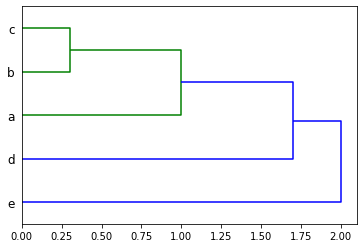

In [17]:
plt.figure()
_ = hclust.dendrogram(hclust.linkage(np.array([1,2,2.3,4,6]).reshape(-1, 1)), orientation = 'right', labels='abcde', distance_sort = 'ascending')
plt.show()

## 2.3 Generative model for real meme generation* (<font color='red'>2p</font>)

This exercise is a preparatory step for the next exercise that allows you to analyse a set of internet election memes. Here we work only with the textual part of a meme. Consider a sentence or a list of sentences arranged in separate rows, each row corresponding to a meme. Your task is to define a probabilistic model that tells how probable it is that one meme is converted to another meme. For that you need to split each meme into a list of words and normalise the words (decapitalise). Next you must define potential modification mechanisms:

* adding words 
* deleting words
* replacing words

The exact probability values are not important as scaling these by a constant does not change the outcome of single linkage clustering algorithm.

After that you can use an existing implementation of weighted edit distance aka weighted Levenshtein distance to get the actual probabilities. This allows you to implement a distance measure that gives out negative log-likelihoods. Test it on a small sample of election memes extracted from [`2016-election-memes.zip`](./data/2016-election-memes/2016-election-memes.zip). 

In [18]:
df = pd.read_csv('data/2016-election-memes/example.csv', encoding='latin1', usecols = range(7))
df['caption']

0    Son killed by\n country, in a\n in a\n war sta...
1    THERE'S ONLY ONE GENDER\n TRUMP IS A HERO\n VE...
2    TRUMP LOVES TRUMP, AND\n DOES WHAT HIS FOLLOWE...
3    Hey Trump! How did you cacth\n up to me in the...
4    WANTED TRUMP FOR\n PRESIDENT\n TRUMPIKICKED HI...
Name: caption, dtype: object

## 2.4 Analysis of election memes* (<font color='red'>2p</font>)

Use the probabilistic model defined above and single linkage clustering to analyse election memes from the archive 
[`2016-election-memes.zip`](./data/2016-election-memes/2016-election-memes.zip). As this dataset is rather large, take a reasonable sample so that you can compute the distance matrix in a reasonable time (ca 30 min). Try to find memes that are used for several election candidates and see how they vary. Visualise results using dendrograms.